In [8]:
import heartpy as hp
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal,stats
import logging
from tqdm import tqdm,trange
import os
import glob
from sklearn.preprocessing import MinMaxScaler, scale, robust_scale,RobustScaler
import scipy

In [18]:
def plot_hist(test,p=(0.5,99.5),lines=True):
    plt.figure()
    median = np.median(test)
    avg = np.average(test)
    std = np.std(test)
    p0 = np.percentile(test, p[0])
    p1 = np.percentile(test, p[1])
    plt.hist(test,bins=100)
    if lines:
        plt.axvline(median,c='orange')
        plt.axvline(avg,c='red')
        plt.axvline(p0,c='black')
        plt.axvline(p1,c='black')
    plt.title(f"median:{median:.3f}, average:{avg:.3f}, std:{std:.3f},\n min:{np.nanmin(test):.3f}, max:{np.nanmax(test):.3f},\n{p[0]:2.1f}%: {p0:.3f}, {p[1]:2.1f}%:{p1:.3f}")

In [19]:
def detect_flat(sig,window,t_flat):
    sig = sig.T
    len_data = sig.shape[1]
    flat_locs_abp = np.ones((len_data - window+1,), dtype=int)
    flat_locs_ppg = np.ones((len_data - window+1,), dtype=int)
    # print(flat_locs_abp.shape)
    # Get the locations where i == i+1 == i+2 ... == i+window
    # efficient-ish sliding window
    # print(data[1, :len_data - window].shape,data[1, 0:len_data - window + 0].shape)
    for i in range(1, window):
        # print(data[1, :len_data - window+1].shape, data[1, i:len_data - window + i+1].shape)
        tmp_abp = (sig[0, :len_data - window+1] == sig[0, i:len_data - window + i+1])
        tmp_ppg = (sig[1, :len_data - window+1] == sig[1, i:len_data - window + i+1])
        flat_locs_abp = (flat_locs_abp & tmp_abp)
        flat_locs_ppg = (flat_locs_ppg & tmp_ppg)
        # print(tmp_abp.shape,tmp_ppg.shape)
        # Extend to be the same size as data
    flat_locs_ppg = np.concatenate((flat_locs_ppg, np.zeros((window - 1,), dtype=bool)))
    flat_locs_abp = np.concatenate((flat_locs_abp, np.zeros((window - 1,), dtype=bool)))
    # print(flat_locs_abp.shape,flat_locs_ppg.shape)
    flat_locs_ppg2 = flat_locs_ppg.copy()
    flat_locs_abp2 = flat_locs_abp.copy()
    # print(flat_locs_abp2.shape,flat_locs_ppg2.shape)
        
    # Mark the ends of the window
    for i in range(1, window):
        flat_locs_abp[i:] = flat_locs_abp[i:] | flat_locs_abp2[:len_data-i]
        flat_locs_ppg[i:] = flat_locs_ppg[i:] | flat_locs_ppg2[:len_data-i]
        
    # Percentages
    per_abp = np.sum(flat_locs_abp) / len_data
    per_ppg = np.sum(flat_locs_ppg) / len_data
    if per_abp > t_flat or per_ppg > t_flat:
        logging.info(f"invalid because of flat lines: {per_ppg}, {per_abp},{np.sum(flat_locs_abp)},{np.sum(flat_locs_ppg)},{np.nanmax(flat_locs_abp)},{np.nanmax(flat_locs_ppg)}")
        return True,None,None
    else:
        return False,flat_locs_ppg,flat_locs_abp
    
def fill_rejected_valleys(sig,v):
    diff_v= np.diff(v)
    # [0,1,1,0,0,1,1,0,0]
    # [ 1,  0, -1,  0,  1,  0, -1,  0]
    old = 0
    old_i = -1
    for i,b in enumerate(diff_v):
        if b:
            if old_i < 0 and b > 0:
                sig[:v[i+1],:]=np.nan
            elif b > 0:
                sig[v[i]:v[old_i+1],:]=np.nan
            old = b
            old_i = i
    if old < 0:
        sig[:v[old_i+1],:]=np.nan

def hampel(vals_orig, k=11, t0=3):
    '''
    vals: pandas series of values from which to remove outliers
    k: size of window (including the sample; 7 is equal to 3 on either side of value)
    '''
    
    #Make copy so original not edited
    vals = vals_orig.copy()[(k-1)//2:-(k-1)//2]
    # print(vals.shape)
    #Hampel Filter
    L = 1.4826
    rolling_window = lambda x: np.lib.stride_tricks.sliding_window_view(x,k)
    rolling_median = np.median(rolling_window(vals_orig),axis=1)
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    rolling_MAD = MAD(rolling_window(vals_orig))
    threshold = t0 * L * rolling_MAD
    difference = np.abs(vals - rolling_median)
    
    '''
    Perhaps a condition should be added here in the case that the threshold value
    is 0.0; maybe do not mark as outlier. MAD may be 0.0 without the original values
    being equal. See differences between MAD vs SDV.
    '''
    
    outlier_idx = difference > threshold
    vals[outlier_idx] = rolling_median[outlier_idx] 
    return vals,outlier_idx
def hampel_peaks(sig,peaks,k=11):
    a = sig[peaks]
    if len(peaks) < k:
        # print(f"### peaks:{len(valid_peak_locs)}, k:{k}, len:{len(sig)}")
        return None
    # a.shape,len(wd['peaklist']),valid_peak_locs
    
    _,i = hampel(a,k=k)
    offset = (k//2)
    loc = peaks[np.where(i)[0]+offset]
    return loc

In [20]:
def butterworth(sig,N=4,btype='bandpass',Wn=[0.5,8],fs=125):
    sos = signal.butter(N,Wn,btype,fs=fs,output='sos')
    return signal.sosfiltfilt(sos,sig)

def chebyshev2(x,order=4,rs=40,Wn=[0.5,15]):
    fs = 125
    filter = signal.cheby2(N=order, Wn=Wn,rs=rs,btype='bandpass',output='sos',fs=fs)
    return signal.sosfiltfilt(filter,x)

### flat

In [277]:
def flat(sig,
         plot=False,
         filter=True,
         abp_norm=(199.98749589709124, 50.0),
         xfrom=0,
         xlen=100000,
         remove_rejected_peaks=False,
         align_signal=False,
         use_autocorr_filter=False):
    if sig is None:
        print("sig is none")
        return None,None
    w_flat = 15    # flat lines window
    w_peaks = 3    # flat peaks window
    w_fix = 15     # flat join window
    w_corr = 500
    t_nan = 125 * 120
    # thresholds
    t_peaks = 0.05 # percentage of tolerated flat peaks
    t_flat = 0.1  # percentage of tolerated flat lines
    t_corr = 0.8

    if plot:
        sig_processed = sig.copy()
    # 0 nanでorをとる
    nan_mask = np.isnan(sig[:,0]) | np.isnan(sig[:,1])
    s = np.sum(~nan_mask)
    if  s < t_nan:
        # logging.info(f"invalid because of short valid signal: {s}")
        # print(f"invalid because of short valid signal: {s}")
        return None,None
    sig = sig[~nan_mask]
    
    
    # ppg_norm = (np.nanmax(sig[:,1]),np.nanmin(sig[:,1]))
    # ppg normalize
    if (sig[:,1]>1).any():
        sig[:,1] /= 4 
    # ppg filter
    if filter: 
        sig[:,1] = chebyshev2(sig[:,1])
    # print("aaa",np.count_nonzero(np.isnan(sig[:,1])))
    # sig[:,0] = (sig[:,0] - abp_norm[1])/(abp_norm[0]-abp_norm[1])
    # sig[:,1] = (sig[:,1] - ppg_norm[1])/(ppg_norm[0]-ppg_norm[1])

        # print(r)
        # r = r / ((np.sqrt(np.sum(t[0]**2)-np.sum(t[0])**2)-np.sqrt(np.sum(t[1]**2)-np.sum(t[1])**2)))

    
    # 1, 2
    is_invalid,flat_locs_ppg,flat_locs_abp=detect_flat(sig,w_flat,t_flat)
    # print(np.count_nonzero(np.isnan(sig[:,1])))
    if is_invalid:
        print("invalid 1")
        return None,None
    # 3 find peaks, calcurate flat peaks rate
    # peaks_abp, peaks_info_abp = signal.find_peaks(sig[:,0],distance=35)
    # print("aaa","aaa",np.count_nonzero(np.isnan(sig[:,1])))
    wd, _ = hp.process(sig[:,1],sample_rate=125.0)
    peaks_ppg  = np.array(wd['peaklist'])[wd['binary_peaklist']==1]
    wd, _ = hp.process(-sig[:,1],sample_rate=125.0)
    valleys_ppg  = np.array(wd['peaklist'])[wd['binary_peaklist']==1]
    # print("aaa","aaa","aaa",peaks_ppg,peaks_info_ppg,np.count_nonzero(np.isnan(sig[:,1])))
    # valleys_ppg, valleys_info_ppg = signal.find_peaks(-sig[:,1],distance=35)
    # if len(peaks_info_ppg['plateau_sizes']) == 0 or len(peaks_info_abp['plateau_sizes']) == 0:
    # # if len(peaks_info_ppg['plateau_sizes']) == 0:
    #     print("invalid 4",peaks_ppg,np.count_nonzero(np.isnan(sig[:,1])))
    #     return None,None
    outlier_peaks = hampel_peaks(sig[:,1],peaks_ppg)
    outlier_valleys = hampel_peaks(sig[:,1],valleys_ppg)
        # 0b autocorr align
    ret = valleys_ppg
    if align_signal:
        for i in range(0,len(sig)-w_corr,w_corr):
            t = sig[i:i+w_corr]
            correlation = signal.correlate(t[:,0], t[:,1], mode='full')[t[:,0].size:t[:,0].size+200]
            lags = signal.correlation_lags(t[:,0].size, t[:,1].size, mode="full")[t[:,0].size:t[:,0].size+200]
            lag = lags[np.argmax(correlation)]
            # print(lag)
            if outlier_peaks is not None:
                sig[:,1][outlier_peaks[np.where((i<=outlier_peaks) &(outlier_peaks<i+w_corr))]-i] = np.nan
            if outlier_valleys is not None:
                sig[:,1][outlier_valleys[np.where((i<=outlier_valleys) &(outlier_valleys<i+w_corr))]-i] = np.nan
            if lag == 0:
                    pass
            assert  lag >= 0
            t[:-abs(lag),1] = t[abs(lag):,1]
            t[-abs(lag):] = np.nan
            sig[i:i+w_corr] = t
            sig[i+w_corr-1] = np.nan
            outlier_valleys[np.where((i<=outlier_valleys) &(outlier_valleys<i+w_corr))] -= lag
        # correlation = signal.correlate(sig[:,0], sig[:,1], mode='full')[sig[:,0].size:]
        # lags = signal.correlation_lags(sig[:,0].size, sig[:,1].size, mode="full")[sig[:,0].size:]
        # lag = lags[np.argmax(correlation)]
        # if outlier_peaks is not None:
        #     sig[:,1][outlier_peaks] = np.nan
        # if outlier_valleys is not None:
        #     sig[:,1][outlier_valleys] = np.nan
        # if lag == 0:
        #         pass
        # assert  lag >= 0
        # sig[:-abs(lag),1] = sig[abs(lag):,1]
        # sig[-abs(lag):] = np.nan
        # if use_autocorr_filter:
        #     r = stats.pearsonr(t[:-abs(lag),0],t[:-abs(lag),1]).statistic
        #     if r < 0.8:
        #         t[:] = np.nan
    else:
        if outlier_peaks is not None:
            sig[:,1][outlier_peaks] = np.nan
        if outlier_valleys is not None:
            sig[:,1][outlier_valleys] = np.nan
    # 4 delete data if too much flat lines/peaks
    # len_data=len(sig)
    # per_ppg =len(peaks_info_ppg['plateau_sizes'])/ len(peaks_info_ppg['plateau_sizes'])
    # per_abp =len(peaks_info_abp['plateau_sizes'])/len(peaks_info_abp['plateau_sizes'])
    # # del
    # if per_ppg > t_peaks:
    #     logging.info(f"invalid because of flat lines: {per_ppg}")
    #     print(f"invalid because of flat lines: {per_ppg}")
    #     return None,None

    # sig[np.where(flat_locs_ppg)[0],:] = np.nan
    # sig[np.where(flat_locs_abp)[0],:] = np.nan
    
    # 7 nan del
    # starts_with_nan = np.isnan(sig[0,0])
    # nan_diff = np.diff(np.isnan(sig[:,0]))
    # nan_border = np.where(nan_diff==1)[0]
    # if not starts_with_nan:
    #     nan_border = nan_border[1:-1]
    # if len(nan_border) % 2 == 1:
    #     nan_border = nan_border[:-1]
    # nan_border = nan_border.reshape(-1,2)
    # nan_length = nan_border[:,1]-nan_border[:,0]
    
    # # print(nan_border[:5],nan_length[:30])
    # for i,l in enumerate(nan_length):
    #     if l < t_nan:
    #         sig[nan_border[i,0]:nan_border[i,1],:]=np.nan
    # # print(len(nan_diff_pos),nan_diff_pos[:5],len(nan_diff_neg),nan_diff_neg[:5])
    # nan_mask = np.isnan(sig[:,0])
    # # leave single nan
    # nan_border = nan_border[np.where(nan_length < t_nan)[0]]
    # nan_mask[nan_border] = False
    # sig = sig[~nan_mask,:]
    # if len(sig) < t_nan:
    #     print("invalid last")
    #     return None
    # print("before:",len_data,"after:",len(sig))

    ret = ret[ret>=0]
    if plot:
        x = np.arange(0,len(sig))
        plt.figure(figsize=(12,4))
        plt.subplot(2,1,1)
        # plt.plot(x,sig_processed[:,0],label='-.',color='black')
        plt.plot(x,sig[:,0])
        # plt.scatter(x[valleys_ppg], sig[valleys_ppg,0], color='red',s=24)
        plt.xlim(xfrom,xfrom+xlen)
        plt.subplot(2,1,2)
        # plt.plot(x,sig_processed[:,1],label='-.',color='black')
        plt.plot(x,sig[:,1])
        # plt.scatter(x[valleys_abp], sig[valleys_abp,1], color='red',s=24)
        plt.xlim(xfrom,xfrom+xlen)
        plt.show()
    return sig,ret

In [95]:
def window(sig,start_locs,px = 512):
    i = 0
    processed = []
    for j in start_locs:
        if j < i:
            print("passed",j)
            continue
        i = j
        if i + px > sig.shape[0]:
            print("end reached",j)
            break
        w = sig[j:j+px]
        if np.isnan(w).any(axis=1).any():
            print("nan",j)
            continue
        else:
            i += px
            Ssqi = stats.skew(w[:,1])
            if Ssqi > 0:
                print("accepted",j)
                processed.append(w)
            else:
                print("skew",j)
    print(processed[0].shape,len(processed))
    ret = np.stack(processed)
    print(ret.shape)
    return ret

In [ ]:
def create_npy_executor_big(dir1):
    px = 256
    dtype=np.float64
    DATA_DIR = r"F:\minowa\BloodPressureEstimation\data\raw\BPDataset\p00"
    OUTPUT_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\0125_align_ppgnorm"
    os.makedirs(f"{OUTPUT_DIR}\\p00",exist_ok=True)
    files = glob.glob(dir1+"\*",root_dir=DATA_DIR)
    scaler_ppg = MinMaxScaler()
    s = []
    print("files:",len(files))
    count = 0
    for i in trange(len(files)):
        sig = np.load(os.path.join(DATA_DIR,files[i]))
        sig = sig.transpose()
        # print(sig.shape)
        sig,start_locs= flat(sig,align_signal=True)
        if start_locs is None:
            count+=1
            continue
        i = 0
        
        processed = []
        for j in start_locs:
            if j < i:
                continue
            i = j
            if i + px > sig.shape[0]:
                break
            w = sig[j:j+px]
            if np.isnan(w).any(axis=1).any():
                continue
            else:
                i += px
                # skewness
                Ssqi = stats.skew(w[:,1])
                if Ssqi > 0:
                    processed.append(w)
        if not len(processed):
            count+=1
            continue
        processed = np.stack(processed).transpose(0,2,1)
        s.append(processed)
        # print(np.stack(processed).shape,processed[0].shape)
    # s  =np.concatenate(s)
    # print(s.shape)
    print("invalid records:",count, "valid records:",1000-count)
    return s
    # else:
    #     print("##### NO SIGNAL:", dir1)

In [263]:
a = np.array([0.,1.,2.,3.,4.,5.,6.])
t = a[2:2+3]
t[:-1] = t[1:]
t[-1:] = np.nan
print(t)
a[2:2+3]=t
print(a)

[ 3.  4. nan]
[ 0.  1.  3.  4. nan  5.  6.]


In [184]:
def ppg_remove_outliers(sig,ppg_t= None,verbose=True):
    min_sig = np.nanmin(sig[:,1],axis=1)
    max_sig= np.nanmax(sig[:,1],axis=1)
    if verbose:
        print(sig.shape,end='->')
    if ppg_t is None:
        ppg_t = (np.percentile(min_sig, 1),np.percentile(min_sig, 99),np.percentile(max_sig, 1),np.percentile(max_sig, 99))
    mask = np.where(~((min_sig <= ppg_t[0]) | (min_sig >= ppg_t[1]) | (max_sig <= ppg_t[2]) | (max_sig >= ppg_t[3])))[0]
    sig = sig[mask]
    if verbose:
        print(sig.shape)
    return sig,ppg_t

def abp_remove_outliers(sigs):
    old_sigs_shape = sigs.shape
    dbp = np.nanmin(sigs[:,0],axis=1)
    sbp = np.nanmax(sigs[:,0],axis=1)
    dbp_final = np.where(dbp>105)[0]
    sbp_final = np.where((sbp < 85) | (sbp >180))[0]
    mask1 = np.where(((sbp>148) & (sbp<148.1)) | ((sbp>185.0) & (sbp<185.21)) |  ((sbp>173) & (sbp<173.1)) | ((sbp>119.0) & (sbp<119.1)))[0]

    mask_flat =  np.full(len(sbp), True)
    mask_flat[mask1] = False
    mask_dbp = np.full(len(sbp), True)
    mask_dbp[dbp_final] = False

    mask_sbp = np.full(len(sbp), True)
    mask_sbp[sbp_final] = False
    mask_abp = mask_dbp & mask_sbp & mask_flat
    sigs = sigs[mask_abp]
    return sigs

In [188]:
from sklearn.preprocessing import MinMaxScaler, scale, robust_scale,RobustScaler
DATA_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\0124_align_nonorm\p00"
OUTPUT_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\0124_align_norm"
os.makedirs(f"{OUTPUT_DIR}\\p00",exist_ok=True)
files = glob.glob(DATA_DIR+"\\*")
print(files)
train = []
val = []
test = []
for i in range(12):
    if i < 9:
        train.append(np.load(files[i]))
    elif i < 10:
        val.append(np.load(files[i]))
    else:
        test.append(np.load(files[i]))
print(len(train),len(val),len(test))
# train = np.concatenate(train).transpose(0,2,1)
# val = np.concatenate(val).transpose(0,2,1)
# test = np.concatenate(test).transpose(0,2,1)
# print(train.shape)
train,ppg_t = ppg_remove_outliers(abp_remove_outliers(train))

val,_ = ppg_remove_outliers(abp_remove_outliers(val),ppg_t)
test,_ = ppg_remove_outliers(abp_remove_outliers(test),ppg_t)

scaler_abp = MinMaxScaler()
train[:,0] = scaler_abp.fit_transform(train[:,0])
val[:,0] = scaler_abp.transform(val[:,0])
scaler_ppg = MinMaxScaler()
test[:,0] = scaler_abp.transform(test[:,0])
train[:,1] = scaler_ppg.fit_transform(train[:,1])
val[:,1] = scaler_ppg.transform(val[:,1])
test[:,1] = scaler_ppg.transform(test[:,1])
np.save(OUTPUT_DIR+"\\p00\\train.npy",train.transpose(0,2,1))
np.save(OUTPUT_DIR+"\\p00\\validate.npy",val.transpose(0,2,1))
np.save(OUTPUT_DIR+"\\p00\\test.npy",test.transpose(0,2,1))
import pickle

with open(OUTPUT_DIR+"//scaler_abp.p",mode="wb") as f:
    pickle.dump(scaler_abp,f)
print(scaler_abp.min_,scaler_abp.scale_,scaler_abp.data_min_,scaler_abp.data_max_,scaler_abp.data_range_)
print(train.shape)

['F:\\minowa\\BloodPressureEstimation\\data\\processed\\BP_npy\\0124_align_nonorm\\p00\\p000000.npy', 'F:\\minowa\\BloodPressureEstimation\\data\\processed\\BP_npy\\0124_align_nonorm\\p00\\p000001.npy', 'F:\\minowa\\BloodPressureEstimation\\data\\processed\\BP_npy\\0124_align_nonorm\\p00\\p000002.npy', 'F:\\minowa\\BloodPressureEstimation\\data\\processed\\BP_npy\\0124_align_nonorm\\p00\\p000003.npy', 'F:\\minowa\\BloodPressureEstimation\\data\\processed\\BP_npy\\0124_align_nonorm\\p00\\p000004.npy', 'F:\\minowa\\BloodPressureEstimation\\data\\processed\\BP_npy\\0124_align_nonorm\\p00\\p000005.npy', 'F:\\minowa\\BloodPressureEstimation\\data\\processed\\BP_npy\\0124_align_nonorm\\p00\\p000006.npy', 'F:\\minowa\\BloodPressureEstimation\\data\\processed\\BP_npy\\0124_align_nonorm\\p00\\p000007.npy', 'F:\\minowa\\BloodPressureEstimation\\data\\processed\\BP_npy\\0124_align_nonorm\\p00\\p000008.npy', 'F:\\minowa\\BloodPressureEstimation\\data\\processed\\BP_npy\\0124_align_nonorm\\p00\\p00

AttributeError: 'list' object has no attribute 'shape'

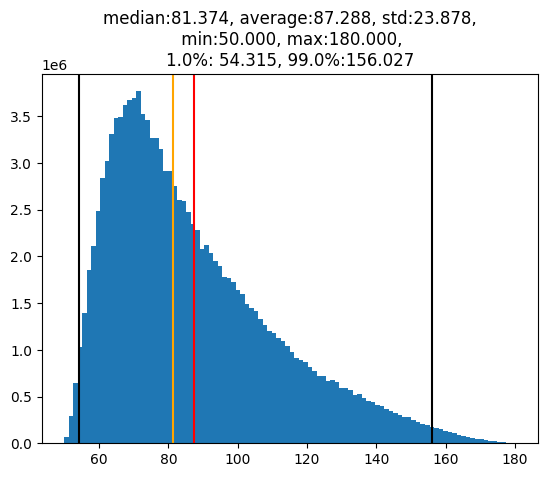

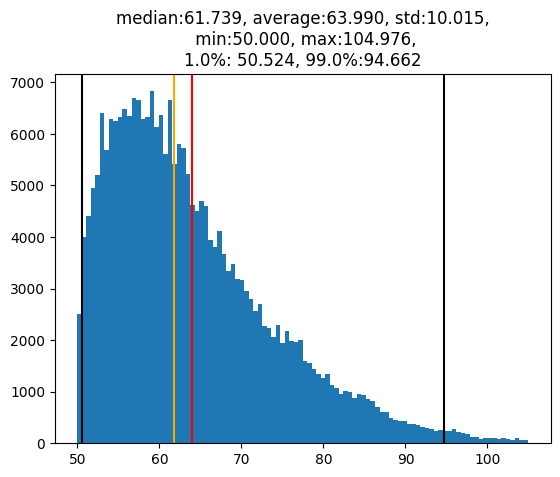

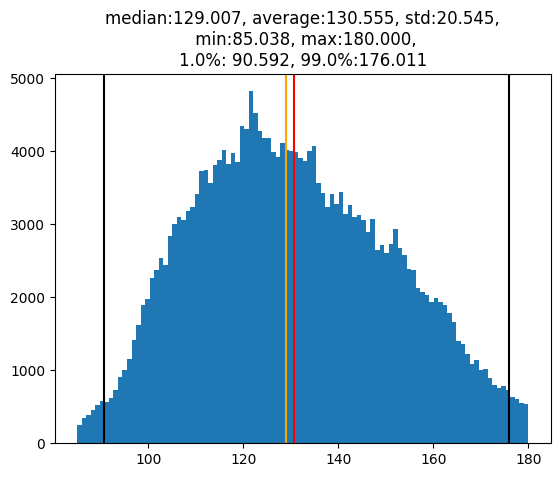

In [139]:
min_sig = np.nanmin(train[:,0],axis=1)
max_sig= np.nanmax(train[:,0],axis=1)
plot_hist(train[:,0].flatten(),(1,99))
plot_hist(min_sig,(1,99))
plot_hist(max_sig,(1,99))

# new

In [278]:
DATA_DIR = r"F:\minowa\BloodPressureEstimation\data\raw\BPDataset\p00"
OUTPUT_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\0125_align_nonorm_256"
os.makedirs(f"{OUTPUT_DIR}\\p00",exist_ok=True)
dirs = glob.glob("p*",root_dir=DATA_DIR)
s2 = []
for i in tqdm(range(len(dirs))):
    out_path = f"{OUTPUT_DIR}\\p00\\{dirs[i]}.npy"
    s = create_npy_executor_big(dirs[i])
    s2.append(s)
# array 12
# array 1000
# (-1, 2, 256)




  0%|          | 0/12 [00:00<?, ?it/s]

files: 1000


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\scipy\interpolate\_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\scipy\interpolate\_fitpack2.py:313: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
  8%|▊         | 1/12 [03:00<33:05, 180.53s/it]

invalid records: 374 valid records: 626
files: 1000


invalid 1


 17%|█▋        | 2/12 [05:45<28:32, 171.22s/it]

invalid records: 446 valid records: 554
files: 1000


 25%|██▌       | 3/12 [07:59<23:07, 154.15s/it]

invalid records: 524 valid records: 476
files: 1000


 33%|███▎      | 4/12 [10:56<21:45, 163.20s/it]

invalid records: 387 valid records: 613
files: 1000


invalid 1
invalid 1


invalid 1


 42%|████▏     | 5/12 [17:28<28:40, 245.72s/it]

invalid records: 319 valid records: 681
files: 1000


invalid 1


 50%|█████     | 6/12 [24:04<29:42, 297.07s/it]

invalid records: 398 valid records: 602
files: 1000


 58%|█████▊    | 7/12 [26:13<20:10, 242.05s/it]

invalid records: 678 valid records: 322
files: 1000


 67%|██████▋   | 8/12 [28:52<14:22, 215.59s/it]

invalid records: 524 valid records: 476
files: 1000


invalid 1


 75%|███████▌  | 9/12 [32:13<10:33, 211.08s/it]

invalid records: 350 valid records: 650
files: 1000


invalid 1


invalid 1


 83%|████████▎ | 10/12 [37:16<07:58, 239.25s/it]

invalid records: 408 valid records: 592
files: 1000


invalid 1


 92%|█████████▏| 11/12 [41:05<03:56, 236.32s/it]

invalid records: 411 valid records: 589
files: 1000


100%|██████████| 12/12 [43:23<00:00, 216.98s/it]

invalid records: 483 valid records: 517


In [272]:
s2[0].shape

(72089, 2, 256)

In [274]:
s_a = []
px =256
for i in range(9):
    for j in range(len(s2[i])):
        s_a.append(s2[i][j])
s_a = np.concatenate(s_a)
print(s_a.shape)     
min_sig = np.nanmin(s_a[:,1],axis=1)
max_sig= np.nanmax(s_a[:,1],axis=1)
s_a = (np.percentile(min_sig, 1),np.percentile(min_sig, 99),np.percentile(max_sig, 1),np.percentile(max_sig, 99))
scaler_ppg = MinMaxScaler()
scaler_abp = MinMaxScaler()
scaler_params = []
for i in range(12):
    p = []
    for j in range(len(s2[i])): 
        s2[i][j],_ = ppg_remove_outliers(abp_remove_outliers(s2[i][j]),s_a,verbose=False)
        if len(s2[i][j]):
            s2[i][j][:,0]= scaler_abp.fit_transform(s2[i][j][:,0].reshape(-1,1)).reshape(-1,px)
            s2[i][j][:,1]= scaler_ppg.fit_transform(s2[i][j][:,1].reshape(-1,1)).reshape(-1,px)
            tmp = np.zeros((s2[i][j].shape[0],2))
            #         X -= self.min_
            # X /= self.scale_
            tmp[:,0] = scaler_abp.min_
            tmp[:,1] = scaler_abp.scale_
            p.append(tmp)
    scaler_params.append(np.concatenate(p))
    s2[i] = np.concatenate(s2[i])


(440247, 2, 256)


In [275]:
train = np.concatenate(s2[:9])
val = s2[9]
test = np.concatenate(s2[10:12])
train_p = np.concatenate(scaler_params[:9])
val_p = scaler_params[9]
test_p = np.concatenate(scaler_params[10:12])

for i in s2:
    print(i.shape)
print(len(train),len(val),len(test))
# train[:,0] = scaler_abp.fit_transform(train[:,0].reshape(-1,1)).reshape(-1,px)
# val[:,0] = scaler_abp.transform(val[:,0].reshape(-1,1)).reshape(-1,px)
# test[:,0] = scaler_abp.transform(test[:,0].reshape(-1,1)).reshape(-1,px)
np.save(OUTPUT_DIR+"\\p00\\train.npy",train.transpose(0,2,1))
np.save(OUTPUT_DIR+"\\p00\\validate.npy",val.transpose(0,2,1))
np.save(OUTPUT_DIR+"\\p00\\test.npy",test.transpose(0,2,1))
np.save(OUTPUT_DIR+"\\p00\\scale_train.npy",train_p)
np.save(OUTPUT_DIR+"\\p00\\scale_validate.npy",val_p)
np.save(OUTPUT_DIR+"\\p00\\scale_test.npy",test_p)
# import pickle
# with open(OUTPUT_DIR+"//scaler_abp.p",mode="wb") as f:
    # pickle.dump(scaler_abp,f)

(52907, 2, 256)
(44680, 2, 256)
(34667, 2, 256)
(50842, 2, 256)
(53823, 2, 256)
(53727, 2, 256)
(22544, 2, 256)
(38198, 2, 256)
(51293, 2, 256)
(47867, 2, 256)
(50883, 2, 256)
(39372, 2, 256)
402681 47867 90255


In [223]:
np.save(OUTPUT_DIR+"\\p00\\scale_train.npy",train_p)
np.save(OUTPUT_DIR+"\\p00\\scale_validate.npy",val_p)
np.save(OUTPUT_DIR+"\\p00\\scale_test.npy",test_p)

In [142]:
def rand_plot(sig,index=None):
    plt.figure()
    if index is None:
        i = np.random.randint(len(sig))
        target = sig[i]
    else:
        i = index[np.random.randint(len(index))]
        target = sig[i]
    print("#",i,target.shape)
    plt.plot(target)

### test

In [ ]:
DATA_ROOT = r"../data/raw/BPDataset/p00"
test = np.load(os.path.join(DATA_ROOT,"p00000"+"0","0000000_"+"0001"+".npy")).T
test.shape

In [224]:
DATA_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\0125_align_norm2\p00\train.npy"
test = np.load(DATA_DIR)


# 7844 (512,)


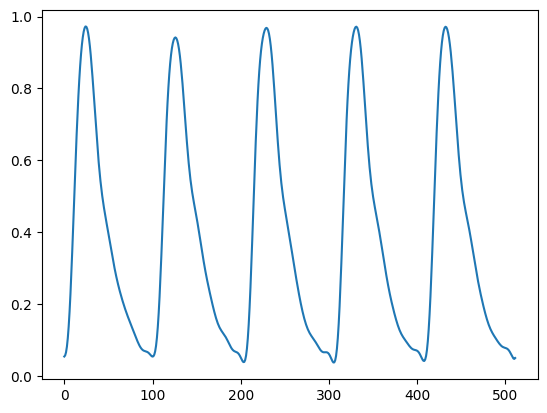

In [227]:
rand_plot(test[:,:,1])

In [228]:
a = np.where(min_sig <= 0.001)
aq = test[a]
print(aq.shape)
rand_plot(aq[:,1])

IndexError: index 248495 is out of bounds for axis 0 with size 248495

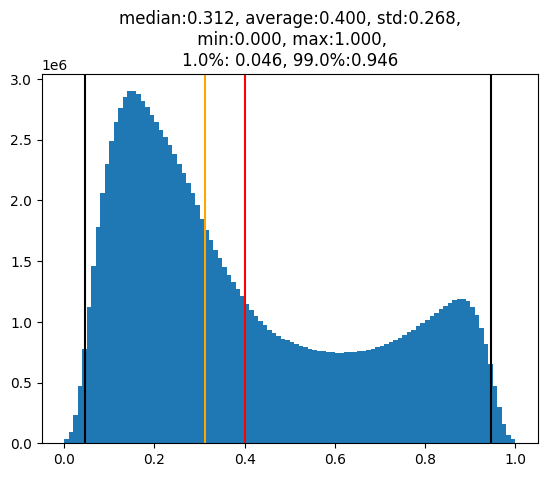

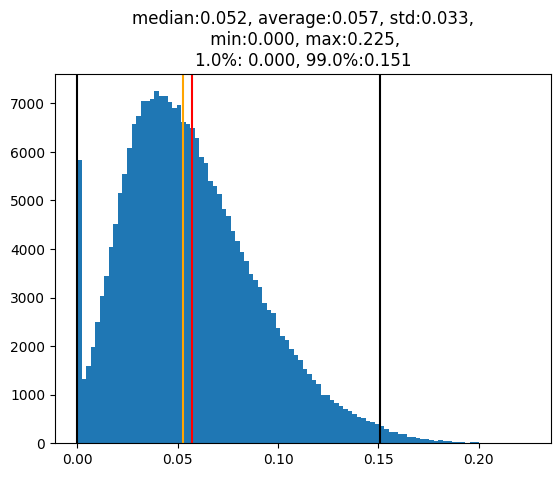

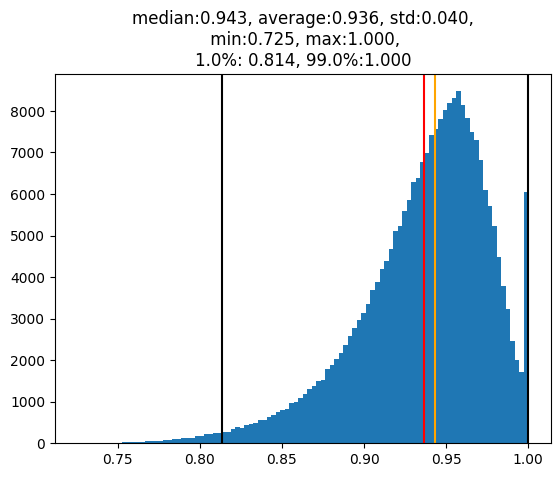

In [232]:
min_sig = np.nanmin(test[:,:,1],axis=1)
max_sig= np.nanmax(test[:,:,1],axis=1)
plot_hist(test[:,:,1].flatten(),(1,99))
plot_hist(min_sig,(1,99))
plot_hist(max_sig,(1,99))

In [100]:
siga,start = flat(test,align_signal=True)

aaa 0
0
aaa aaa 0
aaa aaa aaa [   54   119   184   249   312   377   442   507   570   634   698   761
   824   887   950  1014  1077  1139  1202  1266  1329  1392  1455  1519
  1583  1646  1709  1773  1836  1900  1962  2026  2073  2129  2191  2255
  2319  2382  2445  2508  2572  2636  2701  2764  2828  2892  2957  3020
  3084  3149  3214  3278  3341  3406  3471  3537  3584  3640  3705  3768
  3833  3897  3961  4024  4088  4153  4216  4281  4346  4409  4473  4538
  4603  4666  4730  4794  4858  4923  4986  5051  5115  5179  5241  5301
  5364  5428  5491  5554  5618  5681  5745  5808  5872  5936  5999  6063
  6126  6190  6253  6316  6379  6443  6507  6570  6633  6697  6761  6825
  6887  6926  6962  7005  7046  7111  7173  7237  7300  7364  7428  7491
  7555  7619  7684  7748  7812  7877  7942  8008  8072  8138  8204  8269
  8334  8399  8465  8530  8595  8660  8726  8792  8856  8921  8987  9052
  9117  9182  9248  9313  9378  9443  9507  9571  9634  9698  9760  9824
  9888  9952 10016 10

In [101]:
siga.shape[0]

61000

In [102]:
np.count_nonzero(np.isnan(siga))

168

In [103]:
s_test = window(siga,start)

accepted 8
passed 73
passed 138
passed 203
passed 267
passed 332
passed 396
passed 461
accepted 524
passed 588
passed 652
passed 716
passed 779
passed 841
passed 904
passed 968
passed 1031
accepted 1094
passed 1156
passed 1220
passed 1284
passed 1346
passed 1409
passed 1473
passed 1537
passed 1600
nan 1663
nan 1727
nan 1791
nan 1854
nan 1917
nan 1980
nan 2032
accepted 2083
passed 2145
passed 2209
passed 2273
passed 2337
passed 2400
passed 2463
passed 2526
passed 2590
accepted 2655
passed 2718
passed 2782
passed 2846
passed 2911
passed 2975
passed 3038
passed 3103
nan 3167
nan 3233
nan 3296
nan 3360
nan 3425
nan 3491
nan 3543
accepted 3594
passed 3659
passed 3723
passed 3787
passed 3851
passed 3915
passed 3979
passed 4042
accepted 4107
passed 4170
passed 4235
passed 4300
passed 4363
passed 4427
passed 4492
passed 4557
accepted 4621
passed 4684
passed 4748
passed 4813
passed 4878
passed 4940
passed 5005
passed 5069
accepted 5133
passed 5196
passed 5256
passed 5318
passed 5381
passed 5445

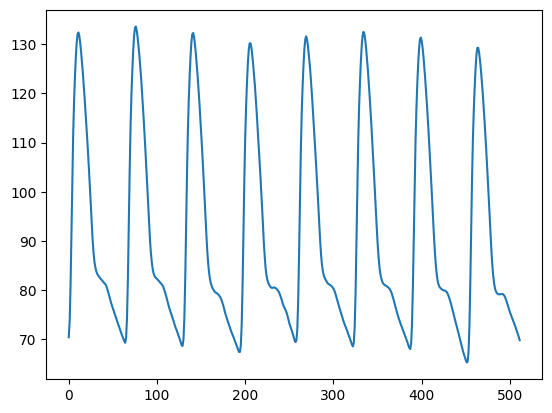

In [104]:
plt.plot(s_test[0,:,0])